In [0]:
import numpy as np
import pandas as pd 

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import scipy.sparse 
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import pickle
from tqdm import tqdm_notebook
from itertools import product
import gc

import warnings
warnings.filterwarnings('ignore')


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here am pinpointing the main steps I follow to create the model for 1C competition:
##So, our journey consists of:
* Getting familiar with the task and data itself
* EDA/cleaning/elaborating on new features/advanced feature engineering
* Creating a base model
* Trying ensembling  (whouaaaah)

Let's launch it!!!

#First of all, let's get familiar with the data and the task we are going to complete
##Task description:

There is data about historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. The difficulty is that the list of shops and products slightly changes every month, so the model should be robust to overcome this.
##File descriptions
**sales_train.csv -** the training set. Daily historical data from January 2013 to October 2015.

**test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.

**sample_submission.csv** - a sample submission file in the correct format.

**items.csv** - supplemental information about the items/products.

**item_categories.csv**  - supplemental information about the items categories.

**shops.csv**- supplemental information about the shops.

In [0]:
#let_s upload the data
items = pd.read_csv('/content/drive/My Drive/kaggle/items.csv')
shops = pd.read_csv('/content/drive/My Drive/kaggle/shops.csv')
cats = pd.read_csv('/content/drive/My Drive/kaggle/item_categories.csv')
train = pd.read_csv('/content/drive/My Drive/kaggle/sales_train.csv', parse_dates=['date'])
# set index to ID to in order to avoid droping it later
test  = pd.read_csv('/content/drive/My Drive/kaggle/test.csv')

In [0]:
for i in [items, shops, cats, train, test]:
  print(i.head(10))
  print()

                                           item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2                40
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3                40
4        ***КОРОБКА (СТЕКЛО)                       D        4                40
5  ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)         ...        5                40
6           ***УДАР ПО ВОРОТАМ (UNI)               D        6                40
7         ***УДАР ПО ВОРОТАМ-2 (UNI)               D        7                40
8           ***ЧАЙ С МУССОЛИНИ                     D        8                40
9      ***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI)             D        9                40

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран

#Some EDA

Text(0.5, 1.0, 'Monthly distribution of  sales sums')

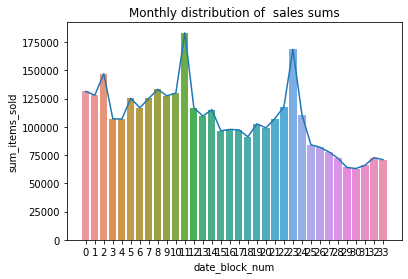

In [0]:
#We predict for a month, so, lets look at monthly distribution
sales_by_month = pd.DataFrame(train.groupby(['date_block_num']).sum().item_cnt_day).reset_index()
sales_by_month.columns = ['date_block_num', 'sum_items_sold']
sns.barplot(x ='date_block_num', y='sum_items_sold', 
            data=sales_by_month.reset_index());

plt.plot(sales_by_month.sum_items_sold)
plt.title('Monthly distribution of  sales sums')


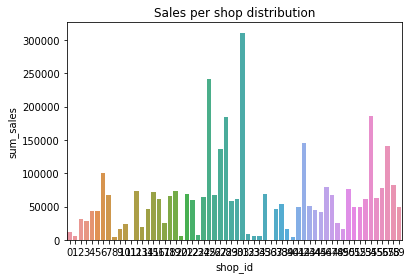

In [0]:
fig = plt.Figure(figsize=[30,10])
sales_by_month_shopid = pd.DataFrame(train.groupby(['shop_id']).sum().item_cnt_day).reset_index()
sales_by_month_shopid.columns = ['shop_id', 'sum_sales']
sns.barplot(x ='shop_id', y='sum_sales', data=sales_by_month_shopid)
plt.title('Sales per shop distribution');



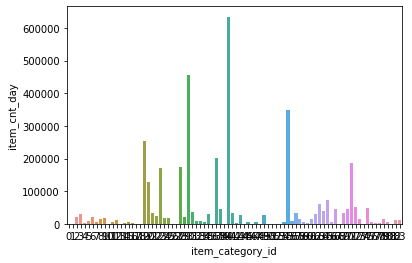

In [0]:
salesitem_cat = train.merge(items, how='left', on='item_id').groupby('item_category_id').item_cnt_day.sum()
sns.barplot(x ='item_category_id', y='item_cnt_day',
            data=salesitem_cat.reset_index(), 
           );


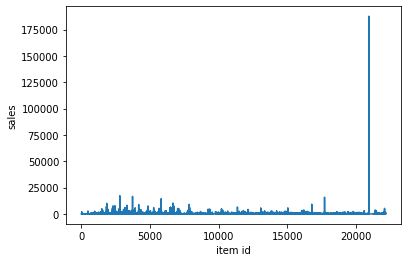

In [0]:
sales_by_itemid = pd.DataFrame(train.groupby(['item_id']).sum().item_cnt_day)
plt.xlabel('item id')
plt.ylabel('sales')
plt.plot(sales_by_itemid)

In [0]:
#there is some weird item (really huge)
huge_item = sales_by_itemid.item_cnt_day.argmax()
huge_item

20949

Text(0.5, 1.0, 'Shop-it with sales per month')

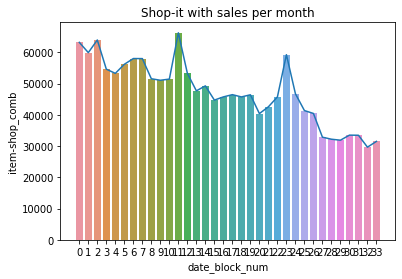

In [0]:
shop_item = pd.DataFrame(train[['date_block_num', 'shop_id', 
                                     'item_id']].drop_duplicates().groupby('date_block_num').size()).reset_index()
shop_item.columns = ['date_block_num', 'item-shop_comb']
sns.barplot(x ='date_block_num', y='item-shop_comb', data=shop_item);
plt.plot(shop_item['item-shop_comb']);
plt.title('Shop-it with sales per month')



##Data leakage

As we've been discussing data leakages in quite details - we should apply the knowledge somehow:) Less then the 50% of the all combinations item-shop that we are present in our data appears in the test set.

In [0]:
train_part = pd.Series(list(train[['item_id', 'shop_id']].itertuples(index=False, name=None)))
test_part = pd.Series(list(test[['item_id', 'shop_id']].itertuples(index=False, name=None)))
print(str(round(train_part.isin(test_part).sum()/len(train_part),2)*100)+'%')

42.0%


##Let's create our data set

We see that tne train data is represented in a few separate tables,therefore, we need to prepare it for training: compile a dataset by joining on ids

Also, we add some new features

P.S. 
About text features: "shop_name" and "item_name": there were trials to somehow use them, but it was rather a failure, so I don't include them in the final version of dataset

The set of ids that appears in our test set, once there is a historical sale present, will be saved every subsequent month . By this we improve our model because it can infer the predictions about items not for sales in the test month (months with zero sales in a row). Also, we create the input for the submission with the date_block_num=34

Lets define a function for creating our dataset

In [0]:
def create_data_set(train, test, items, list_lags, date_block_threshold):
    def downcast_dtypes(df):
    

        # columns to downcast
        float_cols = [c for c in df if df[c].dtype == "float64"]
        int_cols =   [c for c in df if df[c].dtype == "int64"]
        
        df[float_cols] = df[float_cols].astype(np.float32)
        df[int_cols]   = df[int_cols].astype(np.int32)
        
        return df
   
  
    # a "grid" with columns
    index_cols = ['shop_id', 'item_id', 'date_block_num']

    # create a grid from all shops/items combinations from that month for every month
    grid = [] 
    new_items = pd.DataFrame()
    cur_items_aux=np.array([])
    for block_num in train['date_block_num'].unique():
        cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
        cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].append(pd.Series(cur_items_aux)).unique()
        cur_items_aux = cur_items[pd.Series(cur_items).isin(test.item_id)]
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    # create a dataframe out of the grid
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

    # add  shop_id-item_id  from submission to test predictions
    test['date_block_num'] = 34
    grid = grid.append(test[['shop_id', 'item_id', 'date_block_num']])

    #  get shop-item-month aggregates
    shop_item_month = train.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
    # Fix column names
    shop_item_month.columns = [col[0] if col[-1]=='' else col[-1] for col in shop_item_month.columns.values] 
    # Join it to the grid
    all_data = pd.merge(grid, shop_item_month , how='left', on=index_cols).fillna(0)

    # shop-month aggregates
    shop_month = train.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
    shop_month.columns = [col[0] if col[-1]=='' else col[-1] for col in shop_month.columns.values]
    all_data = pd.merge(all_data, shop_month, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # item-month aggregates
    item_month = train.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
    item_month.columns = [col[0] if col[-1] == '' else col[-1] for col in item_month.columns.values]
    all_data = pd.merge(all_data, item_month, how='left', on=['item_id', 'date_block_num']).fillna(0)

    # Downcast dtypes from 64 to 32 bit to save memory
    all_data = downcast_dtypes(all_data)
    
    gc.collect()
    # List of columns for creating lags
    columns_to_rename = list(all_data.columns.difference(index_cols)) 

    shift_range = list_lags

    for month_s in tqdm_notebook(shift_range):
        train_s = all_data[index_cols + columns_to_rename].copy()
    
        train_s['date_block_num'] = train_s['date_block_num'] + month_s
    
        new_n = lambda x: '{}_lag_{}'.format(x, month_s) if x in columns_to_rename else x
        train_s = train_s.rename(columns=new_n)

        all_data = pd.merge(all_data, train_s, on=index_cols, how='left').fillna(0)

    del train_s

    # not using data from year 2013
    all_data = all_data[all_data['date_block_num'] >= date_block_threshold] 

    #  lagged features
    fit_columns = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
    # We will drop these later
    cols_to_drop = list(set(list(all_data.columns)) - (set(fit_columns)|set(index_cols))) + ['date_block_num'] 

    # Category for  item
    item_category_map = items[['item_id','item_category_id']].drop_duplicates()

    all_data = pd.merge(all_data, item_category_map, how='left', on='item_id')
    all_data = downcast_dtypes(all_data)
    gc.collect();
    
    return [all_data, cols_to_drop]

In [0]:
list_lags = [1, 2, 3]
date_block_threshold = 12
sales_for_modelling = train[train.item_id.isin(test.item_id)]
[all_data, to_drop_cols]  = create_data_set(sales_for_modelling, test, items, list_lags, date_block_threshold)

Let's look at what we got here!

In [0]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id
0,54,10297,12,4.0,3416.0,23.0,3.0,42.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,37
1,54,10298,12,14.0,3416.0,182.0,21.0,369.0,4282.0,119.0,1309.0,3085.0,7.0,144.0,2464.0,40
2,54,10300,12,3.0,3416.0,26.0,1.0,54.0,4282.0,31.0,361.0,3085.0,0.0,53.0,2464.0,37
3,54,10292,12,9.0,3416.0,93.0,8.0,156.0,4282.0,16.0,203.0,3085.0,15.0,279.0,2464.0,40
4,54,10143,12,1.0,3416.0,12.0,1.0,18.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,55


In [0]:
all_data.describe()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id
count,3.324774e+06,3.324774e+06,3.324774e+06,3.324774e+06,3.324774e+06,3.324774e+06,3.324774e+06,3.324774e+06,3.324774e+06,3.324774e+06,3.324774e+06,3.324774e+06,3.324774e+06,3.324774e+06,3.324774e+06,3.324774e+06
mean,3.188525e+01,1.083116e+04,2.467748e+01,4.242574e-01,1.305462e+03,2.004739e+01,4.437213e-01,2.083526e+01,1.328432e+03,4.364528e-01,2.046342e+01,1.249924e+03,4.290592e-01,2.021551e+01,1.179763e+03,4.607316e+01
std,1.733908e+01,6.274294e+03,6.390452e+00,4.288682e+00,1.141293e+03,1.268713e+02,4.541590e+00,1.353630e+02,1.146194e+03,4.464906e+00,1.375974e+02,1.139939e+03,4.535408e+00,1.402152e+02,1.136630e+03,1.643984e+01
min,2.000000e+00,3.000000e+01,1.200000e+01,-2.000000e+00,-1.000000e+00,-1.000000e+00,-2.000000e+00,-1.000000e+00,0.000000e+00,-4.000000e+00,-1.000000e+00,0.000000e+00,-4.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00
25%,1.700000e+01,5.101000e+03,2.000000e+01,0.000000e+00,6.950000e+02,1.000000e+00,0.000000e+00,1.000000e+00,7.100000e+02,0.000000e+00,0.000000e+00,6.530000e+02,0.000000e+00,0.000000e+00,5.940000e+02,3.700000e+01
50%,3.300000e+01,1.082700e+04,2.500000e+01,0.000000e+00,1.023000e+03,5.000000e+00,0.000000e+00,5.000000e+00,1.035000e+03,0.000000e+00,5.000000e+00,9.970000e+02,0.000000e+00,4.000000e+00,9.640000e+02,4.300000e+01
75%,4.700000e+01,1.609000e+04,3.000000e+01,0.000000e+00,1.436000e+03,1.500000e+01,0.000000e+00,1.500000e+01,1.455000e+03,0.000000e+00,1.500000e+01,1.427000e+03,0.000000e+00,1.400000e+01,1.375000e+03,5.800000e+01
max,5.900000e+01,2.216700e+04,3.400000e+01,2.253000e+03,1.049500e+04,1.218500e+04,2.253000e+03,1.255700e+04,1.049500e+04,1.305000e+03,1.255700e+04,1.049500e+04,1.305000e+03,1.255700e+04,1.049500e+04,8.300000e+01


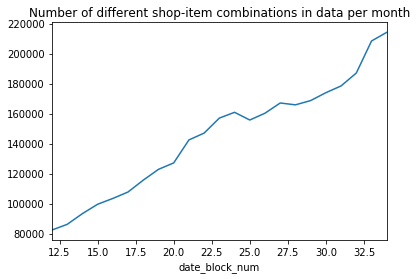

In [0]:
plt.title('Number of different shop-item combinations in data per month')
all_data.groupby('date_block_num').size().plot()

##Advanced feature engineering

In [0]:
#we do mean encoding for ids
mean_encoding_itemcat = pd.DataFrame(all_data.groupby(['shop_id', 
                                                    'item_category_id']).target.agg(['mean', 'var']).reset_index())
mean_encoding_itemcat.columns = ['shop_id', 'item_category_id', 'mean_enc_cat_id', 'var_enc_cat_id']

all_data = pd.merge(all_data, mean_encoding_itemcat, how='left', on=['shop_id', 'item_category_id'])


#Train/test split strategy

Lets create a input dataframe for making the  submission (date_block_num=34).

The target is zero (we miss the information sales for this month). We only get the model input from the table.

The set for validation is associated 
with the months: 22, 31, 32, 33.

In [0]:
subset = all_data[all_data.date_block_num==34].fillna(0)
all_data = all_data[all_data.date_block_num<34].fillna(0)
subset.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id,mean_enc_cat_id,var_enc_cat_id
3110574,5,5037,34,0.0,0.0,0.0,0.0,25.0,1032.0,1.0,110.0,1041.0,3.0,119.0,1218.0,19,0.663426,2.329000
3110575,5,5320,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0.223282,0.406817
3110576,5,5233,34,0.0,0.0,0.0,1.0,42.0,1032.0,3.0,80.0,1041.0,1.0,150.0,1218.0,19,0.663426,2.329000
3110577,5,5232,34,0.0,0.0,0.0,0.0,28.0,1032.0,0.0,48.0,1041.0,1.0,65.0,1218.0,23,0.465819,1.079278
3110578,5,5268,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1.095659,11.922459


In [0]:
dataset = all_data['date_block_num']
mask_test = (dataset.isin([22,31,32,33]))
mask_train = ~mask_test

dates_train = dataset[mask_train]
dates_test  = dataset[mask_test]

X_train = all_data.loc[mask_train].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[mask_test].drop(to_drop_cols, axis=1)

y_train = all_data.loc[mask_train, 'target'].values
y_test =  all_data.loc[mask_test, 'target'].values

Our cross-validation

In [0]:
print(f'Cross-validation is the {round(X_test.shape[0]/X_train.shape[0],2)*100} %' )

Cross-validation is the 30.0 %


In [0]:
tuples_test_submission = pd.Series(list(X_test[['item_id', 'shop_id']][dates_test==33].itertuples(index=False, name=None)))

In [0]:
X_train.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id,mean_enc_cat_id,var_enc_cat_id
0,54,10297,3.0,42.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,37,0.512281,2.742767
1,54,10298,21.0,369.0,4282.0,119.0,1309.0,3085.0,7.0,144.0,2464.0,40,1.120868,10.631319
2,54,10300,1.0,54.0,4282.0,31.0,361.0,3085.0,0.0,53.0,2464.0,37,0.512281,2.742767
3,54,10292,8.0,156.0,4282.0,16.0,203.0,3085.0,15.0,279.0,2464.0,40,1.120868,10.631319
4,54,10143,1.0,18.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,55,0.902726,2.715576


#Now let's model

Firstly, we'll create two base tree models trained with a holdout dataset, estimate them and check the features importance and then go further and do some stacking with a linear model

Step 1. Create a light gradient boosting model and estimate the contributions of the features

In [0]:
#define some functions: to "clip" our data into the intervals and to measure rmse
def clip_20(x):


    return np.clip(x, 0, 20)

def clip_40(x):


    return np.clip(x, 0, 20)

def rmse(*args):


    return np.sqrt(mean_squared_error(*args))

In [0]:
learning_rs = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
best_score = 1
#making a loop for my best estimated parameters to adjust the learning rate
for lr in learning_rs:
    lgb_params = {
               'feature_fraction': 0.7,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**5, 
               'bagging_fraction': 0.7, 
               'learning_rate': lr, 
               'objective': 'mse', 
               'bagging_seed': 2**5, 
               'num_leaves': 2**5,
               'bagging_freq':1,
               'verbose':0 
              }

    lgb_m = lgb.train(lgb_params, lgb.Dataset(X_train, label=clip_40(y_train)), int(100 * (lr / 0.03)))
    pred_lgb_test = lgb_m.predict(X_test)
    score = rmse(clip_20(y_test), clip20(pred_lgb_test))

    if score < best_score:
        best_score = score
        best_lr = lr
        best_lgb = lgb_m

In [0]:
#adjusted lr
best_lr

0.08

In [0]:
#join the sets
#we'll clip y for training to create a difference between y_train, y_test
X = X_train.append(X_test)
y = np.append(y_train, y_test)

In [0]:
#train with the best params
best_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.08, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }
lgb_best = lgb.train(best_params, lgb.Dataset(X, label=clip_40(y)), int(100 * (best_
                                                                               lr / 0.03)))

Now lets see the quality of the model

In [0]:
pred_lgb_test = lgb_best.predict(X_test)
print('Train RMSE for lgb is  %f' % rmse(clip_20(y_train), clip_20(lgb_best.predict(X_train))))
print('Val RMSE for lgb is %f' % rmse(clip_20(y_test), clip_20(pred_lgb_test)))

Train RMSE for lgb is  0.861951
Val RMSE for lgb is 0.820660


And plot the importances

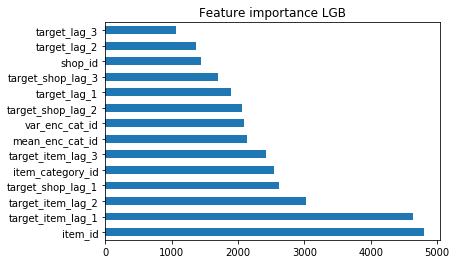

In [0]:
f_importances = pd.Series(lgb_best.feature_importance(), index=X_test.columns)
f_importances = f_importances.nlargest(20)
f_importances.plot(kind='barh')
plt.title('Feature importance LGB')
plt.show()

In [0]:
X = X_train.append(X_test)
Y = np.concatenate([y_train, y_test])
train_ind=np.zeros(X.shape[0])
for i in range(0, len(X_train)):
    train_ind[i] = -1
pred_s = PredefinedSplit(test_fold=(train_ind))

In [0]:
#Here is an example of gridsearch strategy
#but it didn't worked out the last time in my collab environment, so I comment the code and use the parameters that I got earlier
#param_grid={'bootstrap':[0.6, 0.7, 0.8],
            #'max_features':[4, 6, 8], 
            #'max_depth' : [None, 5, 7, 9, 10]}
#gs = GridSearchCV(cv = pred_s, 
                  #estimator = RandomForestRegressor(n_estimators=300, n_jobs=-1), 
                  #param_grid=param_grid, scoring='neg_mean_squared_error')

In [0]:
#gs.fit(X, clip_40(Y))
#best_rf = gs.best_estimator_

In [0]:
bootst_best_params = {"bootstrap":0.7,
                      "criterion":'mse',
                      "max_depth":10,
                      "max_features":6,
                      "max_leaf_nodes":None,
                      "min_impurity_decrease":0.0,
                      "min_impurity_split":None,
                      "min_samples_leaf":1,
                      "min_samples_split":3,
                      "min_weight_fraction_leaf":0.0,
                      "n_estimators":300,
                      "n_jobs":4, 
                      "oob_score":False,
                      "random_state":None,
                      "verbose":0,
                      "warm_start":False}

In [0]:
best_rf = RandomForestRegressor(bootstrap=0.7, criterion='mse', max_depth=10,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [0]:
best_rf.fit(X, clip_40(y))

RandomForestRegressor(bootstrap=0.7, criterion='mse', max_depth=10,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=4,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

Now lets check the quality on the test and train parts

In [0]:
pred_rf_test = clip_20(best_rf.predict(X_test.fillna(0)))
print('Train RMSE for rf is %f' % rmse(clip_20(y_train), clip_20(best_rf.predict(X_train))))
print('Val RMSE for rf is %f' % rmse(clip_20(y_test), pred_rf_test))


Train RMSE for rf is 0.972239
Val RMSE for rf is 0.912222


After having created the two tree-based models we can try stacking, using their predictions as metafeatures for a new model (in this case I try a linear regression one)

Stacking new features in a new dataset

In [0]:
X_test_2 = np.c_[pred_rf_test, pred_lgb_test]

Creating a linear model, training it on our new dataset and checking rmse

In [0]:
lr = LinearRegression()
lr.fit(X_test_2, clip_40(y_test))
pred_lr_test =  clip_20(lr.predict(X_test_2))
print('Test rmse for stacking variables is %f' % rmse(clip_20(y_test), clip_20(pred_lr_test)))

Test rmse for stacking variables is 0.811118


##Creating a submission

Here we follow the same stacking path

In [0]:
pred_test_rf = best_rf.predict(subset.drop(to_drop_cols, axis=1).fillna(0))
pred_test_lgb = lgb_best.predict(subset.drop(to_drop_cols, axis=1).fillna(0))

In [0]:
X_test_2 = np.c_[pred_test_rf, pred_test_lgb]

In [0]:
test_pred = clip_20(lr.predict(X_test_2))

In [0]:
#Finally, produce a table with IDs and our predictions for them for our submission
preds = pd.DataFrame()
preds['shop_id'] = test.shop_id
preds['item_id'] = test.item_id
preds['item_cnt_month'] = test_pred
submision = test[['ID', 'shop_id', 'item_id']].merge(preds, on=['shop_id', 'item_id'], how='left').fillna(0)
submision[['ID', 'item_cnt_month']].to_csv('./submission.csv',index=False)

In [0]:
ans = submision[['ID', 'item_cnt_month']]

In [0]:
#Let's take a look
ans.head()

,ID,item_cnt_month
0,0,0.410433
1,1,0.972884
2,2,0.949934
3,3,0.418861
4,4,0.245406


#That's all, hope, you enjoyed:)
##Have a nice day!
